In [2]:
import numpy as np
import sys
sys.path.insert(0,"../")
import data_generator as gen
import copy
from tqdm import tnrange
import matplotlib.pyplot as plt
new = np.newaxis

debug = False
dprint = print if debug else lambda *args, **kwargs : None

In [2]:
class Tensor():
    
    def __init__(self,elem=None, shape=None, axes_names=None, sigma=1e-3):
        
        # Numeric initialization
        if (elem is None) and (shape is not None):
            #self.elem = np.random.normal(scale=sigma, size=shape)
            self.elem = np.random.random(size=shape) # uniform in [0,1]
            fact = np.sqrt(self.elem.flatten().shape[0])
            #print("fact")
            #print(fact)
            self.elem /= fact/np.sqrt(2) # heuristic normalization
            #self.elem /= np.abs(self.elem).sum()
            #self.elem *= 6
        elif elem is not None:
            self.elem = elem
        else:
            raise Exception('You have to provide either the elements of the tensor or its shape')
            
        # Relevant attributes initialization
        self.shape = self.elem.shape
        self.rank = len(self.shape)
        self.aggregations = {}

        if axes_names is not None:
            try:
                if len(axes_names) == self.rank:
                    self.history_axes_names = [np.array(axes_names)]
                    self.axes_names = np.array(axes_names)
                else:
                    raise ValueError("") # this error is handled with the except ValueError below
            except TypeError:
                print("=== Warning ===\nThe object that describes the indexes names have at least to support the built-in len function."\
                          +"\naxes_names attribute has not been inizialized.")
                self.axes_names = None
            except ValueError:
                print("=== Warning ===\nThe number of names should match the rank of the tensor."\
                          +"\naxes_names attribute has not been inizialized.")
                self.axes_names = None
        else:
            self.axes_names = None

        return


    def transpose(self, permutation):
        # permutation is axes_names in the new order
        indexes = self.ax_to_index(permutation)
        self.elem = np.transpose(self.elem, indexes)
        self.update_members(permutation)
        return

    def ax_to_index(self, axes):
        # handle single and multiple indices separately
        if type(axes) == str:
            return np.where(self.axes_names == axes)[0][0]
        else:
            return_axes = []
            for ax in axes:
                return_axes.append(np.where(self.axes_names == ax)[0][0])
            return return_axes

    
    def aggregate(self, axes_names=None, new_ax_name=None):
        """ 
        Utilization: ...
        """
        # Sanity checks
        if (axes_names is None) and (new_ax_name is not None):
            axes_names = self.axes_names # if axes_names is None -> aggregate all axes
        elif new_ax_name is None:
            raise ValueError("You have to provide the name of the new axes")
            
        if self.axes_names is None:
            raise ValueError("This function can be called only if the axes names are defined")
            
        for name in axes_names:
            assert name in self.axes_names, "The " + name + " axes wasn't found in the tensor"
            
        dprint("Aggregating...")


        # Convert the axes names to their index positions
        indexes = self.ax_to_index(axes_names)
        
        # Store original shape of the aggregated indexes
        axes_sizes = np.array(self.shape)[indexes]
        self.aggregations[new_ax_name] = dict(zip(axes_names, axes_sizes))
        
        # Gather the non contracted indexes
        all_indexes = set(range(len(self.elem.shape)))
        other_indexes = list(all_indexes.difference(set(indexes)))
        other_indexes.sort()

        dprint("axes_numerical+other_axes: ", indexes+other_indexes)

        # Perform actual reshaping
        self.elem = np.transpose(self.elem, indexes+other_indexes)        
        other_sizes = np.array(self.shape)[other_indexes].tolist()
        self.elem = self.elem.reshape([-1]+other_sizes)
        
        # Update class members
        self.update_members(np.concatenate([[new_ax_name], self.axes_names[other_indexes]]))
        
        return
        

    def disaggregate(self, ax):
        """
        
        """
        
        assert ax in self.axes_names, "The " + ax + " ax wasn't found in the tensor."
        assert ax in self.aggregations.keys(), "The " + ax + " does not represent an aggregated ax."
        
        original_dict = self.aggregations[ax]
        original_names = list(original_dict.keys())
        original_shape = list(original_dict.values())
        
        index = self.ax_to_index(ax)
        
        # transpose to have the aggregated index at the beginning
        permutation = [index] + np.arange(index).tolist() + np.arange(index+1, self.rank).tolist()
        self.elem = np.transpose(self.elem, permutation)
        self.update_members(self.axes_names[permutation])
        
        # Disaggregate axis by reshaping the tensor
        self.elem = self.elem.reshape(original_shape + list(self.shape[1:]))
        self.update_members(np.concatenate([original_names, self.axes_names[1:]]))
        
        # Remove aggregated index from the memory
        self.aggregations.pop(ax)
        
        return

    def update_members(self, axes_names):
        self.axes_names = np.array(axes_names)
        self.shape = self.elem.shape
        self.rank = len(self.shape)
        return
    
    def check_names(self):
        print("="*10+"axes_names type"+"="*10)
        print(type(self.axes_names))
        
    def __str__(self):
        print("="*10+" Tensor description "+"="*10)
        print("Tensor shape: ", self.shape)
        print("Tensor rank: ", self.rank)
        print("Axes names: ", self.axes_names)
        return ""
    
    def __add__(self, o): 
        """
        Perform sum of two tensors permuting the axes of the second so that they are alligned.
        """

        # check all names match between two tensors
        assert np.all(np.isin(self.axes_names, o.axes_names)), "Error: axes don't match, cannot sum tensors."

        o.transpose(self.axes_names)
        t3 = self.elem + o.elem
        T3 = Tensor(elem = t3, axes_names = self.axes_names)
        return T3


In [3]:
t = Tensor(shape=[2,3,2], axes_names=['i','j','k'])
print("Original tensor")
print('t.axes_names: ', t.axes_names)
print('t.shape: ', t.shape)
print('t.elem: ', t.elem)
t.aggregate(axes_names=['j','i'], new_ax_name='l')
print('\nAfter first aggregation:')
print('t.axes_names: ', t.axes_names)
print('t.shape: ', t.shape)
print('t.elem: ', t.elem)
t.aggregate(axes_names=['l','k'], new_ax_name='i')
print('\nAfter second aggregation:')
print('t.axes_names: ', t.axes_names)
print('t.shape: ', t.shape)
print('t.elem: ', t.elem)
t.disaggregate('i')
print('\nAfter first disaggregation:')
print('t.axes_names: ', t.axes_names)
print('t.shape: ', t.shape)
print('t.elem: ', t.elem)
t.disaggregate('l')
print('\nAfter second disaggregation:')
print('t.axes_names: ', t.axes_names)
print('t.shape: ', t.shape)
print('t.elem: ', t.elem)

Original tensor
t.axes_names:  ['i' 'j' 'k']
t.shape:  (2, 3, 2)
t.elem:  [[[1.26866671e-01 2.06203563e-01]
  [1.55174032e-02 4.67806306e-02]
  [1.00925131e-01 4.07553273e-01]]

 [[1.99797622e-01 2.21066374e-01]
  [5.34465541e-02 6.18834823e-02]
  [2.63354622e-01 2.92921592e-04]]]

After first aggregation:
t.axes_names:  ['l' 'k']
t.shape:  (6, 2)
t.elem:  [[1.26866671e-01 2.06203563e-01]
 [1.99797622e-01 2.21066374e-01]
 [1.55174032e-02 4.67806306e-02]
 [5.34465541e-02 6.18834823e-02]
 [1.00925131e-01 4.07553273e-01]
 [2.63354622e-01 2.92921592e-04]]

After second aggregation:
t.axes_names:  ['i']
t.shape:  (12,)
t.elem:  [1.26866671e-01 2.06203563e-01 1.99797622e-01 2.21066374e-01
 1.55174032e-02 4.67806306e-02 5.34465541e-02 6.18834823e-02
 1.00925131e-01 4.07553273e-01 2.63354622e-01 2.92921592e-04]

After first disaggregation:
t.axes_names:  ['l' 'k']
t.shape:  (6, 2)
t.elem:  [[1.26866671e-01 2.06203563e-01]
 [1.99797622e-01 2.21066374e-01]
 [1.55174032e-02 4.67806306e-02]
 [5.34

In [4]:
def _contract_(T1, T2, contracted_axis1, contracted_axis2, common_axis1=[], common_axis2=[]):
    
    # use this only if we want to give as input string only
    #common_axis1 = T1.ax_to_index(common_axis1)
    #common_axis2 = T2.ax_to_index(common_axis2)
    #contracted_axis1 = T1.ax_to_index(contracted_axis1)
    #contracted_axis2 = T2.ax_to_index(contracted_axis2)
    
    # Sanity checks
    assert len(common_axis1) == len(common_axis2), "number of common axes is different"
    
    if type(contracted_axis1) != list:
        # assuming contracted_axis1/2 is numeric
        assert T1.shape[contracted_axis1] == T2.shape[contracted_axis2], "dimensions of contracted axes do not match"
        contracted_axis1 = [contracted_axis1]
        contracted_axis2 = [contracted_axis2]
    
    for i in range(len(common_axis1)):
        # assuming common_axis1/2 is numeric
        assert T1.shape[common_axis1[i]] == T2.shape[common_axis2[i]], "dimensions of common axes do not match"
        
    original_shape1 = np.array(T1.shape)
    original_shape2 = np.array(T2.shape)
        
    def perm(contracted_axis, original_shape, common_axis):
        # assuming contracted_axis and common_axis list of integers
        # astype is for handle the case in the first array is empty, in which the function cannot infere the type
        last_axis = np.concatenate((common_axis, contracted_axis)).astype("int64")         

        remaining_axis = np.delete(np.arange(len(original_shape)), last_axis)
        permutation = np.concatenate((remaining_axis, last_axis))
        return permutation

    permutation1 = perm(contracted_axis1, original_shape1, common_axis1)
    permutation2 = perm(contracted_axis2, original_shape2, common_axis2)

    shape1 = original_shape1[permutation1]
    shape2 = original_shape2[permutation2]

    # param for match the rank of the two shapes
    unique1 = len(shape1)-len(common_axis1)-len(contracted_axis1)
    unique2 = len(shape2)-len(common_axis1)-len(contracted_axis1)

    new_shape1 = np.concatenate((shape1[:unique1],[1 for i in range(unique2)],shape1[unique1:])).astype("int64")
    new_shape2 = np.concatenate(([1 for i in range(unique1)],shape2)).astype("int64")
    
    T1.transpose(T1.axes_names[permutation1])
    T2.transpose(T2.axes_names[permutation2])
    #print(T1)
    #T1.elem = np.transpose(T1.elem, permutation1)
    #T2.elem = np.transpose(T2.elem, permutation2)
    #print(T1)

    #if T1.axes_names is not None:
    #T1.axes_names = T1.axes_names[permutation1]
    #T2.axes_names = T2.axes_names[permutation2]
    #print(T1)
    
    T3_axes_names = np.concatenate([T1.axes_names[:unique1], T2.axes_names[:T2.rank-len(contracted_axis2)]])
    #else: 
    #    T3_axes_names = None

    T3 = (T1.elem.reshape(new_shape1)*T2.elem.reshape(new_shape2))
    if len(contracted_axis1) > 0:
        # if len(contracted_axis1) == 0 just to tensor product
        T3 = T3.sum(axis=-1)
        
    T3 = Tensor(elem=T3, axes_names=T3_axes_names)
    return T3

def contract(T1, T2, contracted_axis1=[], contracted_axis2=[], common_axis1=[], common_axis2=[], contracted=None, common=None):
        
    if contracted is not None:
        contracted_axis1 = contracted
        contracted_axis2 = contracted
 
    if common is not None:
        common_axis1 = common
        common_axis2 = common
        
    if type(common_axis1) == int:
        common_axis1 = [common_axis1]
    if type(common_axis2) == int:
        common_axis2 = [common_axis2]

    if type(contracted_axis1) == str:
        #contracted_axis1 = np.where(T1.axes_names == contracted_axis1)[0][0]
        contracted_axis1 = T1.ax_to_index(contracted_axis1)

    if type(contracted_axis2) == str:
        #contracted_axis2 = np.where(T2.axes_names == contracted_axis2)[0][0]
        contracted_axis2 = T2.ax_to_index(contracted_axis2)
        
    temp = []
    for key in common_axis1:
        if type(key) == str:
            temp.append(np.where(T1.axes_names == key)[0][0])
        else:
            temp.append(key)
    common_axis1 = temp
    # should work something like common_axis1 = T1.ax_to_index(common_axis1)

    temp = []
    for key in common_axis2:
        if type(key) == str:
            temp.append(np.where(T2.axes_names == key)[0][0])
        else:
            temp.append(key)
    common_axis2 = temp
    
    return _contract_(T1, T2, contracted_axis1, contracted_axis2, common_axis1, common_axis2)

In [5]:
x = np.random.random([1,2,3,4])
y = np.random.random([3,4,5,6])
T1 = Tensor(x, axes_names=['i','j','k','l'])
T2 = Tensor(y, axes_names=['k','l','n','m'])
T3 = contract(T1,T2, contracted='k', common='l')
print(T3)

========== Tensor description ==========
Tensor shape:  (1, 2, 5, 6, 4)
Tensor rank:  5
Axes names:  ['i' 'j' 'n' 'm' 'l']



In [6]:
def partial_trace(T, ax1, ax2):
    
    traced_axes = np.array([ax1,ax2])
    traced_indexes = T.ax_to_index(traced_axes)
    remaining_axis = np.delete(T.axes_names, traced_indexes)
    permutation = np.concatenate((traced_axes, remaining_axis))
    T.transpose(permutation)
    t = T.elem.trace(axis1=0, axis2=1)
    T = Tensor(elem=t, axes_names=remaining_axis)
    return T

In [7]:
t = Tensor(shape=[3,4,3], axes_names=['i','j','k'])
t1 = partial_trace(t, 'i', 'k')
print(t1)

========== Tensor description ==========
Tensor shape:  (4,)
Tensor rank:  1
Axes names:  ['j']



In [8]:
def tensor_svd(T, threshold=0.999):
    
    if type(T) != Tensor:
        raise TypeError("This function only support object from the class Tensor")

    if len(T.shape) != 2:
        raise ValueError("This function only support a 2D tensors")

    U, S, Vh = np.linalg.svd(copy.deepcopy(T.elem))

    # computing adaptive bond dimension
    cumulative_variance_explained = np.cumsum(S)/S.sum()
    #print(cumulative_variance_explained)
    index = np.argmax(cumulative_variance_explained>threshold)
    m = T.aggregations['i']['left']
    m_new = max(10,min(index,m))
    
    # cut tensors
    Vh = Vh[:m_new,:]
    U = U[:,:m_new]
    S = S[:m_new]
    SVh = Vh*S[:,new]
    
    # building new tensors
    TU = Tensor(elem=U, axes_names=['i','right'])
    TSVh = Tensor(elem=SVh, axes_names=['left','j'])
    TU.aggregations['i'] = T.aggregations['i']
    TSVh.aggregations['j'] = T.aggregations['j']
    
    # retrieving original dimensions
    TU.disaggregate('i')
    TSVh.disaggregate('j')
    
    return TU, TSVh

In [388]:
class Network():
    
    def __init__(self, N, M, D=2, L=10, sigma=1e-2):
        
        self.N = N
        self.D = D
        self.L = L
        
        self.As = []
        
        # sigma as keyword should be removed if uniform initialization is used
        self.As.append(Tensor(shape=[L,M,M,D], axes_names=['l','left','right','d0'], sigma=sigma))
        for i in range(1,N):
            self.As.append(Tensor(shape=[M,M,D], axes_names=['left','right','d'+str(i)], sigma=sigma))
        #self.As.append(Tensor(shape=[M,D], axes_names=['left','d'+str(N-1)], sigma=sigma))
        
        self.l_pos = 0

        
    def forward(self, X, train=False):
        
        assert self.N == X.shape[1], "The 1 dimension of the input data must be the flattened number of pixels"

        # X should be batch_size x 784 x 2
        TX = []
        for i in range(self.N):
            TX.append(Tensor(elem=X[:,i,:], axes_names=['b','d'+str(i)]))
                      
        # This must be futher investigate, three ways:
        #     * numpy vectorize
        #     * list comprehension
        #     * multithread
                      
        #A_TX = np.vectorize(contract)(TX, A, contracted='d'+str(i))
        A_TX = [contract(self.As[i], TX[i], contracted='d'+str(i)) for i in range(self.N)]
        cum_contraction = []
        cum_contraction.append(A_TX[-1])
        for j in range(1,self.N): # instead of self.N - 1
            tmp_cum = copy.deepcopy(cum_contraction[-1])
            tmp_cum = contract(A_TX[-(j+1)], tmp_cum, 'right', 'left', common='b')
            cum_contraction.append(tmp_cum)

        #if train:
        self.cum_contraction = cum_contraction[::-1]
        self.left_contraction = None
        self.TX = TX

        out = partial_trace(self.cum_contraction[0], 'right', 'left') # close the circle
        return out

    def sweep_step(self, f, y, lr, batch_size):
        # ID of the node A at which the output of the net is computed
        l = self.l_pos
        
        # (always true)
        B = contract(self.As[l], self.As[l+1], "right", "left")

        # (always true)
        # computing all elements for delta_B
        # Contributions:
        # - TX[l]    (always))
        # - TX[l+1]    (always))
        # - left_contribution    (for l > 0)
        # - cum_contraction[-(l+2)]    (for l < N-2)
        # - y-f    (always)
        
        phi = contract(self.TX[l], self.TX[l+1], common="b")
        
        if l==0:
            # tensor product with broadcasting on batch axis
            phi = contract(phi, self.cum_contraction[l+2], common = "b")
        
        elif (l > 0) and (l<(self.N-2)):
            # compute new term for the left contribute
            new_contribution = contract(self.As[l-1], self.TX[l-1], contracted='d'+str(l-1))
            #print("new_contribution: \n", new_contribution)
            if l==1:
                # define left_contraction (['right','b'])
                self.left_contraction = new_contribution
            else:
                # update left_contraction (['right','b'])
                self.left_contraction = contract(self.left_contraction, new_contribution, 'right', 'left', common='b')
            #print("self.left_contraction: \n", self.left_contraction)
            #print('self.cum_contraction[l+2]: \n', self.cum_contraction[l+2])
            circle_contraction = contract(self.cum_contraction[l+2], self.left_contraction, 'right', 'left', common='b')
            #print("circle_contraction: \n", circle_contraction)
            # tensor product with broadcasting on batch axis
            phi = contract(phi, circle_contraction, common = "b")
            
        else:
            new_contribution = contract(self.As[l-1], self.TX[l-1], contracted='d'+str(l-1))
            
            # update left_contraction (['right','b'])
            self.left_contraction = contract(self.left_contraction, new_contribution, 'right', 'left', common='b')
            
            # tensor product with broadcasting on batch axis
            phi = contract(phi, self.left_contraction, common = "b")
            
        f.elem = y-f.elem
        #print("phi: \n",phi)
        deltaB = contract(f, phi, contracted="b")
        deltaB.elem *= (lr/batch_size)
        #print("Before SVD")
        #print("self.As[%d]: \n"%(l), self.As[l])
        #print("self.As[%d]: \n"%(l+1), self.As[l+1])
        
        #print("B: \n",B)
        #print("deltaB :\n", deltaB)
        left_index = deltaB.ax_to_index('left')
        right_index = deltaB.ax_to_index('right')
        deltaB.axes_names[left_index] = 'right'
        deltaB.axes_names[right_index] = 'left'
        # update B
        B = B + deltaB

        # compute new output of the net
        out = contract(B, self.TX[l], contracted='d'+str(l))
        out = contract(out, self.TX[l+1], contracted='d'+str(l+1), common='b')
        if l == 0:
            out = contract(out, self.cum_contraction[l+2], 'right', 'left', common = "b")
        elif (l > 0) and (l<(self.N-2)):
            out = contract(self.left_contraction, out, 'right', 'left', common = "b")
            out = contract(out, self.cum_contraction[l+2], 'right', 'left', common = "b")
        else:
            out = contract(self.left_contraction, out, 'right', 'left', common = "b")
        
        out = partial_trace(out, 'right', 'left') # close the circle
        
        # reconstruct optimized network tensors
        B.aggregate(axes_names=['d'+str(l),'left'], new_ax_name='i')
        B.aggregate(axes_names=['d'+str(l+1),'right','l'], new_ax_name='j')
        B.transpose(['i','j'])
        self.As[l], self.As[l+1] = tensor_svd(B)
        #print("After SVD")
        #print("self.As[%d]: \n"%(l), self.As[l])
        #print("self.As[%d]: \n"%(l+1), self.As[l+1])
        
        # update position of l
        self.l_pos += 1
        
        return out
    
    def sweep(self, X, y, lr):
        
        batch_size = len(y)
        f = self.forward(X, train = True)
        y_pred = np.argmax(f.elem, axis=0)
        #print(y_pred)
        #print(y)
        one_hot_y = np.zeros((y.size, self.L))
        one_hot_y[np.arange(y.size),y] = 1
        y = one_hot_y.T
        
        
        # compute accuracy
        
        
        for i in range(self.N-1):
            f = self.sweep_step(f, y, lr, batch_size)
            
        # svd 
        B = contract(self.As[-1], self.As[0], "right", "left")
        # reconstruct optimized network tensors
        B.aggregate(axes_names=['d'+str(self.l_pos),'left'], new_ax_name='i')
        B.aggregate(axes_names=['d0','right','l'], new_ax_name='j')
        B.transpose(['i','j'])
        self.As[-1], self.As[0] = tensor_svd(B)
        #print("self.As[-1]: \n", self.As[-1])
        #print("self.As[0]: \n", self.As[0])
        
        self.l_pos = 0
        return f
    
    def train(self, train_loader, val_loader, lr, n_epochs = 10, early_stopping = False, print_freq = 100):
        train_acc = []
        val_acc = []
        # if early_stopping = False
        for epoch in tnrange(n_epochs, desc="Epoch loop", leave = True):
            epoch_train_acc = np.zeros(len(train_loader))
           
            # train
            print_every = int(len(train_loader)/print_freq)
            for i, data in enumerate(train_loader, 0):
            #for i in tnrange(len(train_loader)):
            #    data = train_loader[i]
                x = np.array([data[i][0] for i in range(len(data))])
                y = np.array([data[i][1] for i in range(len(data))])
                #print("x.shape, y.shape:", x.shape, y.shape) # debug
                f = self.sweep(x, y, lr)
                batch_acc = self.accuracy(x, y, f)
                epoch_train_acc[i] = batch_acc
                if (i+1) % (print_every) == 0:
                    print('\r'+"Epoch %d - train accuracy : %.4f - completed : %.2f "%(epoch, epoch_train_acc[:i].mean(), (i+1)*100/len(train_loader))+'%', end=' ')
            train_acc.append(epoch_train_acc.mean())
            
            # validation
            epoch_val_acc = np.zeros(len(train_loader))
            batch_len = np.zeros(len(train_loader))
            for i, data in enumerate(val_loader, 0):
                x = np.array([data[i][0] for i in range(len(data))])
                y = np.array([data[i][1] for i in range(len(data))])
                batch_acc = self.accuracy(x, y)
                epoch_val_acc[i] = batch_acc
                batch_len[i] = len(x)
                if (i+1) % (print_every) == 0:
                    tmp_val_acc = epoch_val_acc[:i].sum()/batch_len[:i].sum()
                    print('\r'+"Epoch %d - train accuracy : %.4f - val accuracy: %.4f"%(epoch, train_acc[-1], tmp_val_acc), end=' ')

            epoch_val_acc *= batch_len
            val_acc.append(epoch_val_acc.sum()/batch_len.sum())
            print('\r'+"Epoch %d - train accuracy : %.4f - val accuracy: %.4f"%(epoch, train_acc[-1], val_acc[-1]))
        
        return train_acc, val_acc
        
    def accuracy(self, x, y, f=None):
        if f is None:
            f = self.forward(x)
        y_pred = np.argmax(f.elem, axis=0)
        errors = (y!=y_pred).sum()
        accuracy = (len(y_pred)-errors)/len(y_pred)
        return accuracy
        

In [382]:
from torch.utils.data import DataLoader, Dataset, TensorDataset, SubsetRandomSampler

In [383]:
class NumpyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return (self.data[index], self.label[index])

In [384]:
def prepare_dataset(data, label, train_perc, val_perc, train_batch_size, val_batch_size, test_batch_size):
    
    def psi(x):
        x = np.array((np.sin(np.pi*x/2),np.cos(np.pi*x/2)))
        return np.transpose(x, [1,2,0])


    # flatten images
    x = data.reshape(len(data),-1)
    # embedd them
    x = psi(x)
    
    # training/test splitting
    m = int(len(x)*train_perc)
    x_train= x[:m]
    y_train = label[:m]
    x_test =  x[m:]
    y_test = label[m:]
    
    # define custom NumpyDatasets
    train_set = NumpyDataset(x_train, y_train)
    test_set =  NumpyDataset(x_test, y_test)
   
    train_len = int(m*(1-val_perc))
    train_sampler = SubsetRandomSampler(np.arange(train_len))
    val_sampler = SubsetRandomSampler(np.arange(train_len,m))

    train_loader = DataLoader(train_set, train_batch_size, sampler=train_sampler, drop_last=True, collate_fn=lambda x: x)
    val_loader = DataLoader(train_set, val_batch_size, sampler=val_sampler, drop_last=False, collate_fn=lambda x: x)
    test_loader = DataLoader(test_set, test_batch_size, drop_last=False, collate_fn=lambda x: x)

    return train_loader, val_loader, test_loader

In [385]:
(data, label) = gen.create_dataset(5000, sigma=0.7)
batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)

In [389]:
net = Network(N=25, M=20, L=2)#, sigma=0.23)

In [390]:
train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 20)

/home/nicola/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:178: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Epoch 0 - train accuracy : 0.9911 - completed : 25.00 % 

KeyboardInterrupt: 

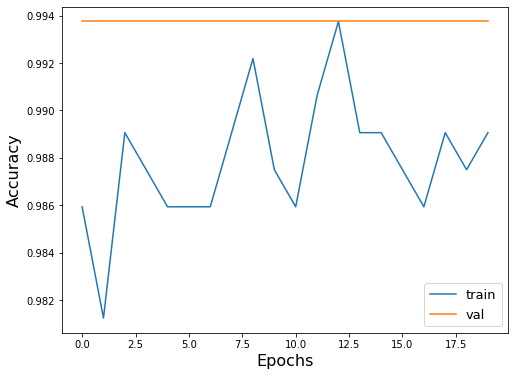

In [246]:
plt.figure(figsize = (8,6))
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.legend(fontsize=13)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.show()

## MNIST dataset

In [391]:
MNIST_data = gen.get_MNIST_dataset(data_root_dir = './datasets', download=False)
train_data, train_labels, test_data, test_labels = MNIST_data

In [397]:
data = np.concatenate((train_data,test_data))
labels = np.concatenate((train_labels,test_labels))
batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(data, labels, 6/7, 0.2, **batch_size)

In [398]:
net = Network(N=784, M=5, L=10)#, sigma=0.23)

In [399]:
train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 10, print_freq=1000)

/home/nicola/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:178: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


Epoch 0 - train accuracy : 0.1156 - completed : 0.70 % 

KeyboardInterrupt: 

In [14]:
    """def aggregate(self, axes_numerical=None, axes_names=None, new_ax_name=None):
            """ 
            #Utilization: ...
            """
            dprint = print if debug else lambda *args, **kwargs : None
            dprint("Aggregating...")

            if (axes_names is None) and (axes_numerical is None):
                self.elem = self.elem.reshape(-1)
                self.shape = self.elem.shape
                self.history_axes_names.append(np.array([new_ax_name]))
                self.axes_names = np.array([new_ax_name])
                return

            if axes_names is not None:
                if axes_numerical is None:
                    axes_numerical = []
                    for name in axes_names:
                        if type(name) == str:
                            if self.axes_names is not None:
                                dprint('name: ', name)
                                dprint('self.axes_names: ', self.axes_names)
                                dprint(np.where(self.axes_names == name))
                                idx = np.where(self.axes_names == name)[0][0]
                                axes_numerical.append(idx)
                            else:
                                raise ValueError("=== Error ===\nThe function was called in the index mode but the tensor wasn't initializated with index names. ")

                    #self.axes_names = np.array([new_ax_name] + list(set(self.axes_names).difference(set(axes_names))))
                    #self.history_axes_names.append(self.axes_names) 
                else:
                    raise Exeption("=== Error ===\nProvide just one input between axes_numerical and axes_names.")


            if (new_ax_name is not None) and (self.axes_names is not None):

                # test this case with new_ax_names and axes_numerical and not axes_names
                if axes_names is None:
                    axes_names = self.axes_names[axes_numerical]

                self.axes_names = np.array([new_ax_name] + list(set(self.axes_names).difference(set(axes_names))))
                self.history_axes_names.append(self.axes_names) 

            all_axes = set(range(len(self.elem.shape)))
            #!!!!!!!!!!!!!!!! check without list AND sort
            other_axes = list(all_axes.difference(set(axes_numerical)))
            other_axes.sort()

            dprint("axes_numerical+other_axes: ", axes_numerical+other_axes)
            self.elem = np.transpose(self.elem, axes_numerical+other_axes)
            self.transposed_shape.append(self.elem.shape)

            self.permutation_history.append(axes_numerical+other_axes)
            self.elem = self.elem.reshape([-1]+list(self.transposed_shape[-1][len(axes_numerical):]))
            self.shape = self.elem.shape

            return

        def disaggregate(self, index):
            """

            """

            try:
                if len(self.permutation_history) > 0:
                    while len(self.permutation_history) > 0:
                        # get and invert last permutation of shape
                        last_permutation = list(self.permutation_history[-1])
                        last_rank = len(last_permutation)
                        permutation_matrix = np.zeros([last_rank,last_rank])
                        permutation_matrix[range(last_rank),last_permutation] = 1
                        # disaggregate using last transposed shape
                        self.elem = self.elem.reshape(self.transposed_shape[-1])
                        # IDEA: original_shape = np.dot(permutation_matrix.T, self.transposed_shape)
                        inverse_permutation = np.where(permutation_matrix.T == 1)[1]
                        self.elem = np.transpose(self.elem, inverse_permutation)
                        # remove history of last aggregation
                        self.permutation_history.pop()
                        self.transposed_shape.pop()

                        if len(self.history_axes_names) > 1:
                            self.history_axes_names.pop()
                            self.axes_names = self.history_axes_names[-1]

                        self.shape = self.elem.shape
                    return
            except:
                print("Cannot disaggregate tensor if it was not aggregated in the first place.")
                return"""
    

IndentationError: unexpected indent (<ipython-input-14-07ddec2f9b25>, line 4)

In [ ]:
    """
class Network():
    
    def __init__(self, N, M, D=2, L=10, sigma=1e-2):
        
        self.N = N
        self.D = D
        self.L = L
        
        self.As = []
        
        # sigma as keyword should be removed if uniform initialization is used
        self.As.append(Tensor(shape=[L,M,D], axes_names=['l','right','d0'], sigma=sigma))
        for i in range(1,N-1):
            self.As.append(Tensor(shape=[M,M,D], axes_names=['left','right','d'+str(i)], sigma=sigma))
        self.As.append(Tensor(shape=[M,D], axes_names=['left','d'+str(N-1)], sigma=sigma))
        
        self.l_pos = 0

        
    def forward(self, X, train=False):
        
        assert self.N == X.shape[1], "The 1 dimension of the input data must be the flattened number of pixels"

        # X should be batch_size x 784 x 2
        TX = []
        for i in range(self.N):
            TX.append(Tensor(elem=X[:,i,:], axes_names=['b','d'+str(i)]))
                      
        # This must be futher investigate, three ways:
        #     * numpy vectorize
        #     * list comprehension
        #     * multithread
                      
        #A_TX = np.vectorize(contract)(TX, A, contracted='d'+str(i))
        A_TX = [contract(self.As[i], TX[i], contracted='d'+str(i)) for i in range(self.N)]
        cum_contraction = []
        cum_contraction.append(A_TX[-1])
        for j in range(self.N-1):
            tmp_cum = copy.deepcopy(cum_contraction[-1])
            tmp_cum = contract(A_TX[-(j+2)], tmp_cum, 'right', 'left', common='b')
            cum_contraction.append(tmp_cum)

        if train:
            self.cum_contraction = cum_contraction
            self.left_contraction = None
            self.TX = TX

        return cum_contraction[-1]

    def sweep_step(self, f, y, lr):
        # ID of the node A at which the output of the net is computed
        l = self.l_pos
        
        # (always true)
        B = contract(self.As[l], self.As[l+1], "right", "left")

        # (always true)
        # computing all elements for delta_B
        # Contributions:
        # - TX[l]    (always))
        # - TX[l+1]    (always))
        # - left_contribution    (for l > 0)
        # - cum_contraction[-(l+2)]    (for l < N-2)
        # - y-f    (always)
        
        phi = contract(self.TX[l], self.TX[l+1], common="b")
        
        # compute new term for the left contribute
        if l > 0:
            new_contribution = contract(self.As[l-1], self.TX[l-1], contracted='d'+str(l-1))
            if l==1:
                # define left_contraction (['right','b'])
                self.left_contraction = new_contribution
            else:
                # update left_contraction (['right','b'])
                self.left_contraction = contract(self.left_contraction, new_contribution, 'right', 'left', common='b')

            # tensor product performed if no axes is contracted
            phi = contract(phi, self.left_contraction, common='b')
            
        if l<(self.N-2):
            # for all but the last optimization step there is a contribution from the right part
            phi = contract(phi, self.cum_contraction[-(l+2)], common = "b")
        
        f.elem = y-f.elem
        deltaB = contract(f, phi, contracted="b")
        deltaB.elem *= lr

        # define tensor_sum for this
        B = tensor_sum(B, delta_B)
        
        # this is bad + in general we will have 2 aggregation steps
        B.aggregate(axes_names=['d1','right','l'], new_ax_name='j')
        
        # d0 -> something else ('i')
        B.transpose(['d0','j'])
        print(B)
        # self.As[l], self.As[l+1] = tensor_svd(B)
        
        # we could just optimize B and return f
        return B #, f
    
    def sweep(self, X, y, lr):
        #g = self.forward(np.ones(X.shape), train = True)
        #print("="*100)
        #for A in self.cum_contraction:
        #    print(A.elem.sum())
        #print("="*100)
        #print(g.elem)
        f = self.forward(X, train = True)
        one_hot_y = np.zeros((y.size, self.L))
        one_hot_y[np.arange(y.size),y] = 1
        y = one_hot_y.T
        B = self.sweep_step(f, y, lr)
        return B
    
    def train():
        return"""

array([ 4,  8, 12, 16, 20, 24, 28])